In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_model_optimization as tfmot

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
print(train_images.shape)
print(train_labels.shape)
train_images = train_images / 255.0
test_images = test_images / 255.0

(60000, 28, 28)
(60000,)


In [2]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 5, input_shape = (28, 28, 1)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2),
    tf.keras.layers.Conv2D(64, 5),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2),
    tf.keras.layers.Conv2D(96, 3),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = 'softmax')
])
model.compile(optimizer = 'adam', 
    loss = 'sparse_categorical_crossentropy', 
    metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 re_lu (ReLU)                (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 re_lu_1 (ReLU)              (None, 8, 8, 64)          0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                    

In [3]:
save_dir = "./logs/"
save_path = save_dir + "model_v1"
# model = tf.keras.models.load_model(save_path)
# loss, acc = model.evaluate(test_images, test_labels)
# print('Test accuracy : ', "{:0.2%}".format(acc))

In [4]:
quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(model)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [5]:
q_aware_model.compile(optimizer = 'adam', 
    loss = 'sparse_categorical_crossentropy', 
    metrics = ['accuracy'])
q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 28, 28, 1)        3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 24, 24, 32)       833       
 erV2)                                                           
                                                                 
 quant_re_lu (QuantizeWrappe  (None, 24, 24, 32)       3         
 rV2)                                                            
                                                                 
 quant_max_pooling2d (Quanti  (None, 12, 12, 32)       1         
 zeWrapperV2)                                                    
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 8, 8, 64)         5

In [6]:
train_log = q_aware_model.fit(train_images, train_labels,
    batch_size = 64,
    epochs = 15,
    validation_data = (test_images, test_labels))

Epoch 1/15
938/938 [==============================] - 24s 24ms/step - loss: 0.5762 - accuracy: 0.7894 - val_loss: 0.4515 - val_accuracy: 0.8437
Epoch 2/15
938/938 [==============================] - 23s 24ms/step - loss: 0.3636 - accuracy: 0.8690 - val_loss: 0.3620 - val_accuracy: 0.8675
Epoch 3/15
938/938 [==============================] - 22s 23ms/step - loss: 0.3118 - accuracy: 0.8854 - val_loss: 0.3251 - val_accuracy: 0.8830
Epoch 4/15
938/938 [==============================] - 23s 25ms/step - loss: 0.2790 - accuracy: 0.8980 - val_loss: 0.3072 - val_accuracy: 0.8880
Epoch 5/15
938/938 [==============================] - 21s 23ms/step - loss: 0.2538 - accuracy: 0.9079 - val_loss: 0.3023 - val_accuracy: 0.8886
Epoch 6/15
938/938 [==============================] - 21s 23ms/step - loss: 0.2341 - accuracy: 0.9140 - val_loss: 0.2848 - val_accuracy: 0.8982
Epoch 7/15
938/938 [==============================] - 21s 22ms/step - loss: 0.2145 - accuracy: 0.9218 - val_loss: 0.2753 - val_accuracy:

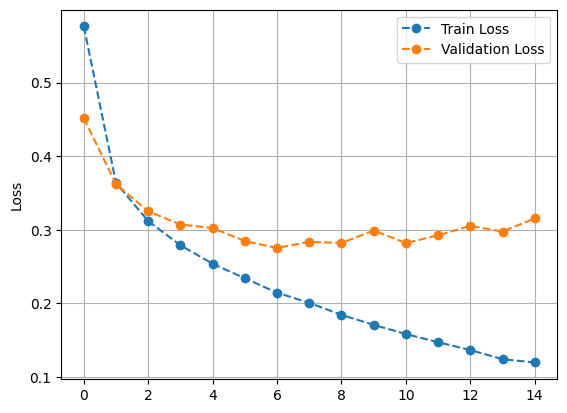

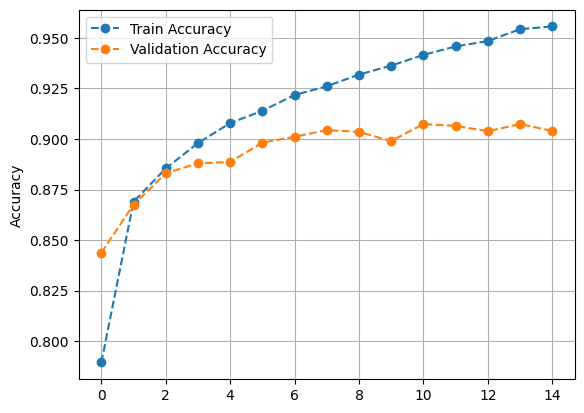

In [7]:
fig = plt.figure()
plt.plot(train_log.history['loss'], label = 'Train Loss', linestyle = '--', marker = 'o')
plt.plot(train_log.history['val_loss'], label = 'Validation Loss', linestyle = '--', marker = 'o')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

fig = plt.figure()
plt.plot(train_log.history['accuracy'], label = 'Train Accuracy', linestyle = '--', marker = 'o')
plt.plot(train_log.history['val_accuracy'], label = 'Validation Accuracy', linestyle = '--', marker = 'o')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [25]:
q_aware_test_loss, q_aware_test_acc = q_aware_model.evaluate(test_images, test_labels)
print('Test accuracy : ', "{:0.2%}".format(q_aware_test_acc))

313/313 [==============================] - 2s 6ms/step - loss: 0.3156 - accuracy: 0.9040
Test accuracy :  90.40%


In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
quantized_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\rosal\AppData\Local\Temp\tmpn5a5gtdh\assets


INFO:tensorflow:Assets written to: C:\Users\rosal\AppData\Local\Temp\tmpn5a5gtdh\assets
c:\Users\rosal\py_master_project\lib\site-packages\tensorflow\lite\python\convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [22]:
def evaluate_model(interpreter: tf.lite.Interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    # print("Shape : ", test_image.shape)
    test_image = np.expand_dims(test_image, axis = 0).astype(np.float32)
    test_image = np.expand_dims(test_image, axis = 3).astype(np.float32)
    # print("New Shape : ", test_image.shape)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels).mean()
  return accuracy

In [26]:
interpreter = tf.lite.Interpreter(model_content = quantized_tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape: ", input_details[0]['shape'])
print("Output Shape: ", output_details[0]['shape'])

test_accuracy = evaluate_model(interpreter)

print('Quant TFLite test_accuracy:', test_accuracy)
print('Quant TF test accuracy:', q_aware_test_acc)

Input Shape:  [ 1 28 28  1]
Output Shape:  [ 1 10]
Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Quant TFLite test_accuracy: 0.9046
Quant TF test accuracy: 0.9039999842643738


In [75]:
for i, layer in enumerate(q_aware_model.layers):
    print(layer.name, len(layer.get_weights()))
    for j in range(len(layer.get_weights())):
        # print(layer.get_weights()[j].shape)
        pass
print(q_aware_model.layers[2].get_weights()[0])

quantize_layer 3
quant_conv2d 3
quant_re_lu 3
quant_max_pooling2d 1
quant_conv2d_1 3
quant_re_lu_1 3
quant_max_pooling2d_1 1
quant_conv2d_2 3
quant_re_lu_2 3
quant_max_pooling2d_2 1
quant_flatten 1
quant_dense 7
-1


In [69]:

ind_index = 10
test_image = test_images[ind_index]
test_image = np.expand_dims(test_image, axis = 0).astype(np.float32)
test_image = np.expand_dims(test_image, axis = 3).astype(np.float32)

interpreter.set_tensor(input_details[0]['index'], test_image)
interpreter.invoke()
output_array = interpreter.get_tensor(output_details[0]['index'])
# print(output_array.shape)
digit = np.argmax(output_array[0])
probability = max(output_array[0])
print("Input index : ", test_labels[ind_index])
print("Output index : ", digit, "{0:.2%}".format(probability))


Input index :  4
Output index :  4 99.61%


In [77]:
# interpreter.allocate_tensors()
tensor_details = interpreter.get_tensor_details()

for dict in tensor_details:
    i = dict['index']
    tensor_name = dict['name']
    scales = dict['quantization_parameters']['scales']
    zero_points = dict['quantization_parameters']['zero_points']
    tensor = interpreter.tensor(i)()
    
    print(i, tensor_name, scales.shape, zero_points.shape, tensor.shape)

0 serving_default_conv2d_input:0 (0,) (0,) (1, 28, 28, 1)
1 sequential/quant_flatten/Const (0,) (0,) (2,)
2 sequential/quant_conv2d/BiasAdd/ReadVariableOp (32,) (32,) (32,)
3 sequential/quant_conv2d_1/BiasAdd/ReadVariableOp (64,) (64,) (64,)
4 sequential/quant_conv2d_2/BiasAdd/ReadVariableOp (96,) (96,) (96,)
5 sequential/quant_conv2d/Conv2D (32,) (32,) (32, 5, 5, 1)
6 sequential/quant_conv2d_1/Conv2D (64,) (64,) (64, 5, 5, 32)
7 sequential/quant_conv2d_2/Conv2D (96,) (96,) (96, 3, 3, 64)
8 sequential/quant_dense/BiasAdd/ReadVariableOp (1,) (1,) (10,)


ValueError: Tensor data is null. Run allocate_tensors() first

In [78]:
save_dir = "./logs/"
save_path = save_dir + "q_model_v1"
# quantized_tflite_model.save(save_path)
# open(tflite_file, "wb").write(quantized_tflite_model)

AttributeError: 'bytes' object has no attribute 'save'